In [1]:
%matplotlib inline



Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(450),
        transforms.Resize(size=(224,224)),
        #transforms.RandomResizedCrop(224),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(90),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.7631, 0.5474, 0.5717], [0.0369, 0.0466, 0.0506])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(450),
        transforms.Resize(size=(224,224)),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.7631, 0.5474, 0.5717], [0.0369, 0.0466, 0.0506])
    ]),
}

data_dir = 'lesion_data_multiclass'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



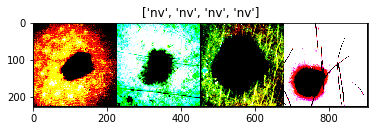

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    mean = np.array([0.7631, 0.5474, 0.5717])
    
    #std = np.array([0.229, 0.224, 0.225])
    std = np.array([0.0369, 0.0466, 0.0506])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
#softmax for converting result into probabilities
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 2.0
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch != 0:
                    scheduler.step(epoch_loss)
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                val_acc.append(epoch_acc)
                val_loss.append(epoch_loss)
                

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss, train_acc, val_loss, val_acc
    

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
def get_results (predictions):
    df = pd.read_csv('HAM10000_metadata.csv')
    val_ids = pd.read_csv('val_split_info.csv')
    df['malignant'] = pd.DataFrame((df['dx'] == 'akiec') | (df['dx'] == 'mel') | (df['dx'] == 'bcc'))
    df['validation'] = df['image_id'].isin(val_ids['image'].values).values
    df = df.sort_values(by = 'image_id')

    df_test = df[df['validation'] == 1]
    y_test = pd.DataFrame(df_test['dx'])
    
    confusion = confusion_matrix(y_test,predictions)
    print(confusion)
    
    
    # classification metrics (https://stackoverflow.com/a/43331484/8614827)
    FP = confusion.sum(axis=0) - np.diag(confusion)  
    FN = confusion.sum(axis=1) - np.diag(confusion)
    TP = np.diag(confusion)
    TN = confusion.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    # metrics used on MTEC website
    print(ACC.mean()) #accuracy
    print(TPR.mean()) #sensitivity
    print(TNR.mean()) #specificity
    print(metrics.f1_score(y_test, predictions, average=None).mean()) #F1-score

    

In [9]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [10]:
def test_model(model, data_transforms, phase):
    
    data_path = 'lesion_data_multiclass/'+phase



    train_dataset = ImageFolderWithPaths(
        root=data_path,
        transform=data_transforms
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,batch_size=4, shuffle=False, num_workers=4
    )


    probabs = pd.DataFrame()
    names = pd.DataFrame()

    running_corrects =0.0
  

    for inputs, labels, paths in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)


        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # add probabilities to DataFrame
        for element in range (inputs.size(0)):
            probabs = probabs.append(pd.Series(np.apply_along_axis(softmax, 1, outputs.detach().cpu().numpy())[element]),ignore_index=True)
            names =names.append([paths[element].replace('lesion_data_multiclass/val/akiec/','').replace('.jpg','')
                                 .replace('lesion_data_multiclass/val/bcc/','').replace('lesion_data_multiclass/val/bkl/','')
                                .replace('lesion_data_multiclass/val/df/','').replace('lesion_data_multiclass/val/mel/','')
                                .replace('lesion_data_multiclass/val/nv/','').replace('lesion_data_multiclass/val/vasc/','')])

        running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / dataset_sizes['val']
    print(' Acc: {:.4f}'.format(acc))

        
    probabs.columns = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    names = names.reset_index().drop(['index'],axis=1)
    probabs['image'] = names
    probabs = probabs.sort_values(by='image')
    probabs = probabs.reset_index()
    
    return probabs
    

In [11]:
def evaluate_model (probabs):
    classes = probabs[['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']]
    #classes.columns = [False,True]
    predictions = classes.idxmax(axis=1)
    get_results(predictions)
    

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [12]:
model_ft = models.resnet18(pretrained=True)
#model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
#optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

#Reduce LR if gradient is stuck on a plateau for past "X=patience" epochs
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft,factor=np.sqrt(0.1),cooldown=0,
                                                 patience=3, min_lr =0.4e-6, verbose=1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [13]:
model_ft,train_loss, train_acc, val_loss, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.8999 Acc: 0.6938
val Loss: 0.7186 Acc: 0.7499

Epoch 1/4
----------
train Loss: 0.7463 Acc: 0.7389
val Loss: 0.6200 Acc: 0.7790

Epoch 2/4
----------
train Loss: 0.6712 Acc: 0.7604
val Loss: 0.5960 Acc: 0.7929

Epoch 3/4
----------
train Loss: 0.6331 Acc: 0.7792
val Loss: 0.5686 Acc: 0.8021

Epoch 4/4
----------
train Loss: 0.5989 Acc: 0.7864
val Loss: 0.5748 Acc: 0.7945

Training complete in 8m 6s
Best val Loss: 0.568595


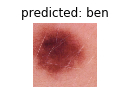

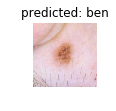

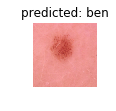

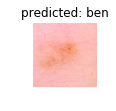

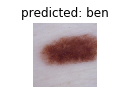

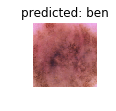

In [19]:
visualize_model(model_ft)

In [14]:
probabs = test_model(model_ft,data_transforms['val'],'val')

 Acc: 0.8021


In [15]:
evaluate_model(probabs)

[[  45   10   23    0    2    4    0]
 [  20   76    5    1    5   20    2]
 [   5    6  208    0   17   38    1]
 [   8    3    9    1    0    9    0]
 [   8    4   31    0  110  124    3]
 [   4   15   76    0   31 1543    8]
 [   0    1    2    0    2    0   31]]
0.9434488251692553
0.5840888863812452
0.9477669950327817
0.5750459845471659


ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [21]:
#model_conv = torchvision.models.resnet18(pretrained=True)
model_conv = torchvision.models.resnet152(pretrained=True)


for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
#optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.0001)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [22]:
model_conv,train_loss, train_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


Process Process-36:
Process Process-35:
Process Process-33:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-34:
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/paperspace/anaconda3/lib/python3.6/multipr

KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/paperspace/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


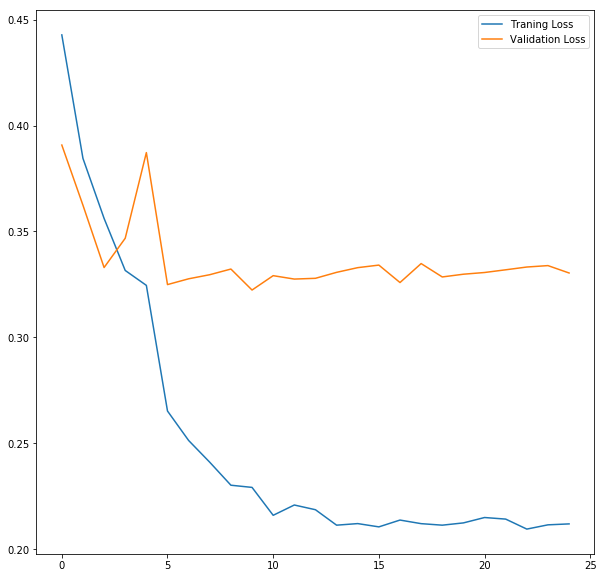

In [16]:
#Loss
f = plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Traning Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

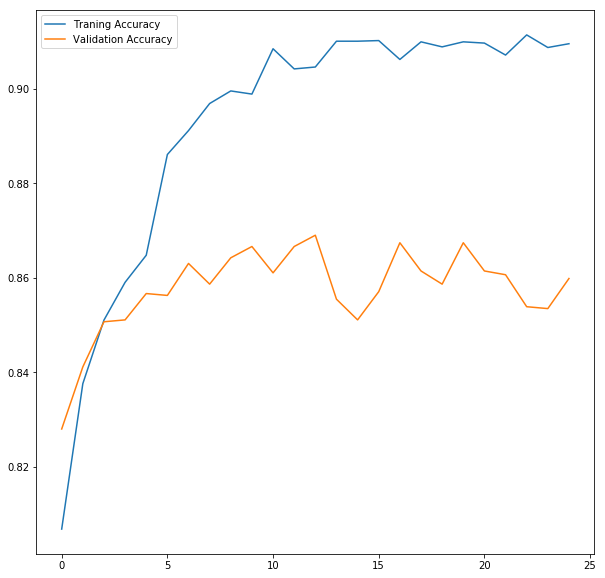

In [17]:
#Accuracy
f = plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Traning Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.show()

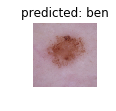

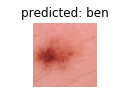

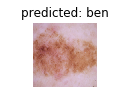

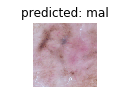

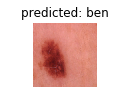

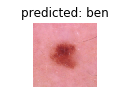

In [52]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [83]:
probabs = test_model(model_conv,data_transforms['val'],'val')

 Acc: 0.7563


In [16]:
probabs = probabs.drop(['index'], axis = 1)

In [17]:
probabs = probabs[['image', 'mel', 'nv','bcc','akiec','bkl','df','vasc']]

In [18]:
probabs.to_csv('multiclass_classification.csv', index=False)

In [19]:
probabs.head()

,image,mel,nv,bcc,akiec,bkl,df,vasc
0,ISIC_0024312,0.126498,0.084019,0.101842,0.071614,0.557796,0.047307,0.010925
1,ISIC_0024317,0.025086,0.959382,0.000016,0.000019,0.015307,0.000173,0.000017
2,ISIC_0024318,0.095185,0.247186,0.048968,0.032397,0.117926,0.410994,0.047343
3,ISIC_0024324,0.020887,0.101058,0.000623,0.000305,0.874435,0.001815,0.000877
4,ISIC_0024328,0.255834,0.589395,0.004009,0.023742,0.123473,0.002969,0.000578


In [28]:
evaluate_model(probabs)

[[1992   26]
 [ 447   46]]
0.8116288331342095
0.540211122212461
0.540211122212461
0.5283533310433424


In [44]:
model_ft.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu):

In [94]:
activation['conv1'].squeeze().size()

torch.Size([512, 7, 7])

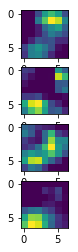

In [97]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model_ft.layer1.register_forward_hook(get_activation('conv1'))
data, _ = image_datasets['val'][0]
data.unsqueeze_(0)
model_ft.to('cuda')
data = data.to('cuda')
output = model_ft(data)

act = activation['conv1'].squeeze()
#fig, axarr = plt.subplots(act.size(0))
fig, axarr = plt.subplots(4)
for idx in range(4):
    axarr[idx].imshow(act[idx])